# 6. Transfer Learning in TensorFlow - Fine Tuning

In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf

tf.__version__

'2.9.1'

In [2]:
# Check if we're using a GPU
!nvidia-smi

Wed Jul  6 17:35:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P8     7W /  N/A |     83MiB /  6144MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Import helper functions we're going to use in this notebook
from extras.helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Lets get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem

In [4]:
# Get 10% of train data of 10 classes of Food101
!curl "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip" --output "Data/Classification/10_food_classes_10_percent.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  160M    0 17996    0     0  17489      0  2:40:37  0:00:01  2:40:36 17505
  3  160M    3 5054k    0     0  2843k      0  0:00:57  0:00:01  0:00:56 2842k
  7  160M    7 12.8M    0     0  4735k      0  0:00:34  0:00:02  0:00:32 4735k
 12  160M   12 20.2M    0     0  5503k      0  0:00:29  0:00:03  0:00:26 5502k
 17  160M   17 28.8M    0     0  6180k      0  0:00:26  0:00:04  0:00:22 6180k
 24  160M   24 39.0M    0     0  6929k      0  0:00:23  0:00:05  0:00:18 8427k
 28  160M   28 46.5M    0     0  7038k      0  0:00:23  0:00:06  0:00:17 8529k
 35  160M   35 57.1M    0     0  7525k      0  0:00:21  0:00:07  0:00:14 9075k
 37  160M   37 60.8M    0     0  6869k      0  0:00:23  0:00:09  0:00:14 7845k
 41  160M   41 67.4M    0     0  6901k      0  0:00

In [5]:
zip_file = zipfile.ZipFile("Data/Classification/10_food_classes_10_percent.zip")
zip_file.extractall("Data/Classification")
zip_file.close()

In [6]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("Data/Classification/10_food_classes_10_percent")

There are 2 directories and 0 images in 'Data/Classification/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'Data/Classification/10_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in 'Data/Classif

In [7]:
# Create training and test directory paths
train_dir = "Data/Classification/10_food_classes_10_percent/train"
test_dir = "Data/Classification/10_food_classes_10_percent/test"

This time instead of using `ImageDataGenerator` we'll use `tf.keras.preprocessing.image_dataset_from_directory`. This is because it creates a `tf.data.Dataset` object which is much faster to process.

In [8]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
for images, labels in train_data.take(1):
    print(images.shape)
    print(labels.shape)

(32, 224, 224, 3)
(32, 10)


## Modelling experiments we're running
|Experiment|Data|Preprocessing|Model|
|----------|----|-------------|-----|
|Model 0 (baseline)|10 classes of Food101 data (random 10% training data only)|None|Feature Extractor: EfficientNetB0 (pretrained on ImageNet, all layers frozen) with no top|
|Model 1|10 classes of Food101 data (random 1% training data only)|Random Flip, Rotation, Zoom, Height, Width data augmentation|Same as Model 0|
|Model 2|Same as Model 0|Same as Model 1|Same as model 0|
|Model 3|Same as Model 0|Same as Model 1|Fine-tuning: Model 2 (EfficientNetB0 pre-trained on ImageNet) with top layer trained on custom data, top 10 layers unfrozen|
|Model 4|10 classes of Food101 data (100% training data)|Same as Model 1|Same as Model 3|

## Keras Sequential vs Functional API

Sequential API
sequential_model = tf.keras.Sequential(<br>
    [<br>
        tf.keras.layers.Flatten(),<br>
        tf.keras.layers.Dense(64, activation = "relu")<br>
        tf.keras.layers.Dense(64, activation = "relu")<br>
        tf.keras.layers.Dense(10, activation = "softmax")<br>
    ], name = "sequential_model"<br>
)<br>

Functional API<br>
inputs = tf.keras.layers.Input(shape = (28,28))<br>
x = tf.keras.layers.Flatten()(inputs)<br>
x = tf.keras.layers.Dense(64, activation = "relu")(x)<br>
x = tf.keras.layers.Dense(64, activation = "relu")(x)<br>
outputs = tf.keras.layers.Dense(10, activation = "softmax")(x)<br>
functional_model = tf.keras.Model(inputs, outputs, name = "functional_model")<br>


Similarities: compiling, fitting, evaluating
Differences: model construction (the Functional API is more flexible and able to produce more sophisticated models)

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order

But the functional API gives us more flexibility with our models.

In [12]:
# 1. Create the base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top = False,
)

# 2. Freeze the base model (so that the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create the inputs into our model
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer")

# 4. If using Resnet50v2 you will need to normalize inputs; dont need to for efficient-net
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs) 

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through the base model: {x.shape}")

# 6. Average Pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after passing inputs through the global average pooling layer model: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs, name = "model_0")
model_0.summary()

Shape after passing inputs through the base model: (None, 7, 7, 1280)
Shape after passing inputs through the global average pooling layer model: (None, 1280)
Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
__________________

In [13]:
# Compile the model
model_0.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_0 = model_0.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [create_tensorboard_callback("TensorBoard/Classification", "efficientnetb0_feature_extractor")]
)

Saving TensorBoard log files to: TensorBoard/Classification/efficientnetb0_feature_extractor/20220706-173620
Epoch 1/5
24/24 [==============================] - 24s 523ms/step - loss: 1.8352 - accuracy: 0.4693 - val_loss: 1.2655 - val_accuracy: 0.7640
Epoch 2/5
24/24 [==============================] - 9s 386ms/step - loss: 1.0762 - accuracy: 0.7827 - val_loss: 0.8453 - val_accuracy: 0.8352
Epoch 3/5
24/24 [==============================] - 9s 402ms/step - loss: 0.7696 - accuracy: 0.8453 - val_loss: 0.6838 - val_accuracy: 0.8524
Epoch 4/5
24/24 [==============================] - 9s 402ms/step - loss: 0.6235 - accuracy: 0.8613 - val_loss: 0.5971 - val_accuracy: 0.8600
Epoch 5/5
24/24 [==============================] - 10s 402ms/step - loss: 0.5337 - accuracy: 0.8853 - val_loss: 0.5453 - val_accuracy: 0.8652


In [14]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 89ms/step - loss: 0.5453 - accuracy: 0.8652


[0.545299768447876, 0.8651999831199646]

In [15]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [16]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

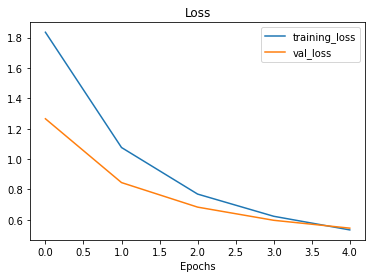

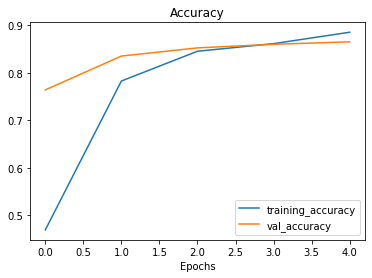

In [17]:
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Lets demonstrate the Global Average Pooling 2D Layer...

We have a tensor after our model goes through `base_model` of shape (None, 7,7, 1280)

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Lets use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [18]:
# Define the input shape
input_shape = (1,4,4,3)
tf.random.set_seed(42)

input_vector = tf.random.normal(shape = input_shape)
output = tf.keras.layers.GlobalAveragePooling2D()(input_vector)
input_vector.shape, output.shape

(TensorShape([1, 4, 4, 3]), TensorShape([1, 3]))

In [19]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_vector, axis = [1, 2]), output

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>)

## Concept of a Feature Vector

* A feature vector is a learned representation of the input data (a compressed form of the input data based on how the model sees it)

Input Data -> EfficientNetB0 (frozen;pretrained on ImageNet) -> Pooling -> Dense -> Output vector

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data.... how about we set up a bunch of experiments to find out:
1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning tranfer learning on 100% of the training data with data augmentation.

> Note: throughout all experiments the same test dataset will be used to evaluate our model...this ensures consistency across evaluation metrics.

In [20]:
# Download and unzip data
if os.path.exists("Data/Classification/10_food_classes_1_percent.zip") == False:
    !curl "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip" --output "Data/Classification/10_food_classes_1_percent.zip"
    zip_file = zipfile.ZipFile("Data/Classification/10_food_classes_1_percent.zip")
    zip_file.extractall("Data/Classification")
    zip_file.close()
    os.remove("Data/Classification/10_food_classes_1_percent.zip")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  127M    0   508    0     0    493      0 75:16:58  0:00:01 75:16:57   494
  4  127M    4 5904k    0     0  3539k      0  0:00:36  0:00:01  0:00:35 3539k
 12  127M   12 16.0M    0     0  6170k      0  0:00:21  0:00:02  0:00:19 6170k
 21  127M   21 27.2M    0     0  7598k      0  0:00:17  0:00:03  0:00:14 7598k
 30  127M   30 38.2M    0     0  8396k      0  0:00:15  0:00:04  0:00:11 8395k
 38  127M   38 49.4M    0     0  8928k      0  0:00:14  0:00:05  0:00:09 10.6M
 46  127M   46 59.6M    0     0  9158k      0  0:00:14  0:00:06  0:00:08 10.7M
 54  127M   54 70.0M    0     0  9347k      0  0:00:13  0:00:07  0:00:06 10.7M
 63  127M   63 80.4M    0     0  9503k      0  0:00:13  0:00:08  0:00:05 10.6M
 67  127M   67 86.5M    0     0  9168k      0  0:00

In [21]:
train_dir_1_percent = "Data/Classification/10_food_classes_1_percent/train"
test_dir_1_percent = "Data/Classification/10_food_classes_1_percent/test"

In [22]:
walk_through_dir("Data/Classification/10_food_classes_1_percent/train")

There are 10 directories and 0 images in 'Data/Classification/10_food_classes_1_percent/train'.
There are 0 directories and 7 images in 'Data/Classification/10_food_classes_1_percent/train\chicken_curry'.
There are 0 directories and 7 images in 'Data/Classification/10_food_classes_1_percent/train\chicken_wings'.
There are 0 directories and 7 images in 'Data/Classification/10_food_classes_1_percent/train\fried_rice'.
There are 0 directories and 7 images in 'Data/Classification/10_food_classes_1_percent/train\grilled_salmon'.
There are 0 directories and 7 images in 'Data/Classification/10_food_classes_1_percent/train\hamburger'.
There are 0 directories and 7 images in 'Data/Classification/10_food_classes_1_percent/train\ice_cream'.
There are 0 directories and 7 images in 'Data/Classification/10_food_classes_1_percent/train\pizza'.
There are 0 directories and 7 images in 'Data/Classification/10_food_classes_1_percent/train\ramen'.
There are 0 directories and 7 images in 'Data/Classificati

In [23]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode = "categorical",
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,

)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_1_percent,
    label_mode = "categorical",
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [24]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:
* tf.keras.layers.experimental.preprocessing()

We can see the benefits of doing this within Tensorflow data augmentation documentation

Off the top of our heads, after reading the docs, the benefits of using data augmentation within the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [25]:
# Create data augmentation stage with horiontal flipping, rotations, zooms, etc
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
        tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
        # tf.keras.layers.experimental.preprocessing.Rescaling(1./255) # Keep for models like ResNet50V2 but EfficientNet doesn't need this
    ], name = "data_augmentation"
)

When passed as a layer to a model, data augmentation is automatically turned on during training (augments training data) but turned off during inference (does not augment testing data or new unseen data)

### Visualise our data augmentation layer (and see what happens to our data)

In [26]:
import matplotlib.image as mpimg
import random
import matplotlib.pyplot as plt

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "Data/Classification/10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir +"/"+random_image
print(random_image_path)

Data/Classification/10_food_classes_1_percent/train/chicken_wings/311554.jpg


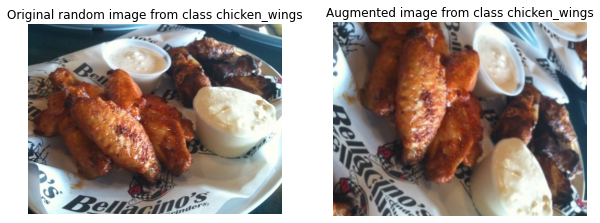

In [27]:
img = mpimg.imread(random_image_path)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img);
plt.axis(False);
plt.title(f"Original random image from class {target_class}");

augmented_img = data_augmentation(tf.expand_dims(img, axis = 0), training = True)
plt.subplot(1,2,2)
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.axis(False);
plt.title(f"Augmented image from class {target_class}");

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [28]:
input_shape = IMG_SIZE +(3,)
input_shape

(224, 224, 3)

In [29]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")

# Add in the data augmentation layer
x = data_augmentation(inputs)

# Give the base_model the inputs (after augmentation) and don't train it
x = base_model(x, training = False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# Make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

In [30]:
# Compile the model
model_1.compile(loss = "categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ["accuracy"])

# Fit the model
history_1 = model_1.fit(
    train_data_1_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_1_percent),
    validation_data = test_data,
    validation_steps = int(0.25*len(test_data)),
    callbacks = [create_tensorboard_callback("TensorBoard/Classification","1_percent_augmented_data_effnetb0_feature_extraction")]
)

Saving TensorBoard log files to: TensorBoard/Classification/1_percent_augmented_data_effnetb0_feature_extraction/20220706-173750
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.4456 - accuracy: 0.1000 - val_loss: 2.2662 - val_accuracy: 0.1497
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 2.1857 - accuracy: 0.2571 - val_loss: 2.1122 - val_accuracy: 0.2533
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9545 - accuracy: 0.4000 - val_loss: 2.0160 - val_accuracy: 0.3339
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8333 - accuracy: 0.4714 - val_loss: 1.9067 - val_accuracy: 0.3914
Epoch 5/5
3/3 [==============================] - 4s 1s/step - loss: 1.6571 - accuracy: 0.6286 - val_loss: 1.8140 - val_accuracy: 0.4655


In [31]:
model_1.evaluate(test_data)

79/79 [==============================] - 7s 91ms/step - loss: 1.8064 - accuracy: 0.4624


[1.806382417678833, 0.46239998936653137]

What! Just 7 images per class and we're getting a decent enough accuracy.

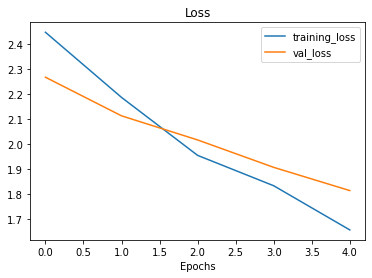

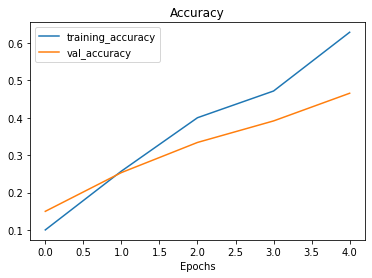

In [32]:
plot_loss_curves(history_1)

## Model 2: Feature Extraction Transfer Learning Model with 10% of data and data augmentation

In [33]:
# model_2 is the same as model 1.
# model_2 = tf.keras.models.clone_model(model_1)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")

# Add in the data augmentation layer
x = data_augmentation(inputs)

# Give the base_model the inputs (after augmentation) and don't train it
x = base_model(x, training = False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# Make a model using the inputs and outputs
model_2 = tf.keras.Model(inputs, outputs)

In [34]:
# Compile the model
model_2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

## Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off

In [35]:
# Set checkpoint path
checkpoint_path = "Checkpoint/Classification/ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose = 1
                                                         )

In [36]:
# Fit the model
history_2 = model_2.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = int(0.25*len(test_data)),
    callbacks = [create_tensorboard_callback("TensorBoard/Classification","10_pct_aug_data_effnetb0_feature_extractor"), checkpoint_callback]
)

Saving TensorBoard log files to: TensorBoard/Classification/10_pct_aug_data_effnetb0_feature_extractor/20220706-173826
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9616 - accuracy: 0.3693
Epoch 1: saving model to Checkpoint/Classification/ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 22s 664ms/step - loss: 1.9616 - accuracy: 0.3693 - val_loss: 1.4227 - val_accuracy: 0.6776
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2749 - accuracy: 0.7093
Epoch 2: saving model to Checkpoint/Classification/ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 13s 525ms/step - loss: 1.2749 - accuracy: 0.7093 - val_loss: 0.9422 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9758 - accuracy: 0.7760
Epoch 3: saving model to Checkpoint/Classification/ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [================

In [45]:
results_model_2 = model_2.evaluate(test_data)

79/79 [==============================] - 8s 100ms/step - loss: 0.6157 - accuracy: 0.8396


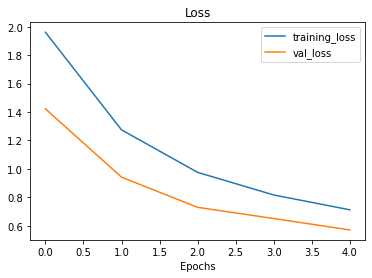

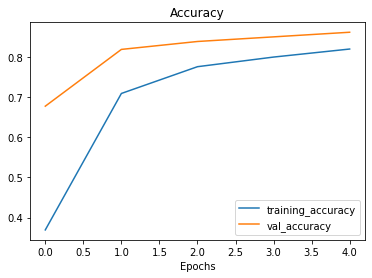

In [38]:
plot_loss_curves(history_2)

### Loading in checkpointed weights
Loading in checkpointed weights returns a model to a specific checkpoint.

In [46]:
model_2.load_weights(checkpoint_path)

In [48]:
results_loaded_model_2 = model_2.evaluate(test_data)

79/79 [==============================] - 8s 93ms/step - loss: 0.6157 - accuracy: 0.8396


We didn't get the same accuracy. What has happened here?

In [49]:
np.isclose(results_model_2, results_loaded_model_2)

array([ True,  True])

In [51]:
np.asarray(results_loaded_model_2) - np.asarray(results_model_2)

array([5.96046448e-08, 0.00000000e+00])

## Model 3: Fine-Tuning an existing model on 10% of data

Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data

In [56]:
# See the layers in model_2
for layer_num, layer in enumerate(model_2.layers):
    print(f"{layer_num}. {layer.name} => {layer.trainable}")

0. input_layer => True
1. data_augmentation => True
2. efficientnetb0 => False
3. global_average_pooling_layer => True
4. output_layer => True


In [58]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [65]:
# To begin fine-tuning let's start by setting the last 10 layers of our base_model as trainable
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile the model (we have to recompile our models every time we make a change)
model_2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), # when fine-tuning you typically want to lower the learning rate by 10x
    metrics = ["accuracy"]
)

When fine-tuning a model you typically want to lower the learning rate by some factor. How much? This is a hyperparameter you can tune. But a good rule of thumb is atleast 10x (though different sources will claim other values). A good resource for information on this is the ULMFiT paper.

In [63]:
print(len(model_2.layers[2].trainable_variables))

10


In [67]:
# Fine tune for another 5 epochs
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(
    train_data,
    epochs = fine_tune_epochs,
    validation_data = test_data,
    validation_steps = int(0.25*len(test_data)),
    initial_epoch = history_2.epoch[-1], # start training from previous last epoch
    callbacks = [create_tensorboard_callback(dir_name = "TensorBoard/Classification", experiment_name="10_pct_fine_tune_last_10")]
)

Saving TensorBoard log files to: TensorBoard/Classification/10_pct_fine_tune_last_10/20220706-182644
Epoch 5/10
24/24 [==============================] - 27s 621ms/step - loss: 0.6070 - accuracy: 0.8240 - val_loss: 0.4279 - val_accuracy: 0.8668
Epoch 6/10
24/24 [==============================] - 11s 450ms/step - loss: 0.5021 - accuracy: 0.8520 - val_loss: 0.4035 - val_accuracy: 0.8602
Epoch 7/10
24/24 [==============================] - 11s 464ms/step - loss: 0.4203 - accuracy: 0.8787 - val_loss: 0.3625 - val_accuracy: 0.8717
Epoch 8/10
24/24 [==============================] - 11s 447ms/step - loss: 0.3725 - accuracy: 0.8907 - val_loss: 0.3849 - val_accuracy: 0.8684
Epoch 9/10
24/24 [==============================] - 11s 455ms/step - loss: 0.3534 - accuracy: 0.8840 - val_loss: 0.3732 - val_accuracy: 0.8783
Epoch 10/10
24/24 [==============================] - 12s 502ms/step - loss: 0.3118 - accuracy: 0.9053 - val_loss: 0.3783 - val_accuracy: 0.8783


In [68]:
results_fine_tune_10_pct = model_2.evaluate(test_data)

79/79 [==============================] - 8s 92ms/step - loss: 0.4066 - accuracy: 0.8640


In [69]:
results_loaded_model_2

[0.6157079339027405, 0.8396000266075134]

Ah! We've gained some accuracy there!

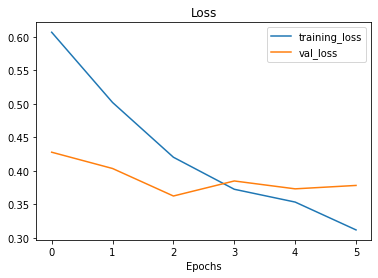

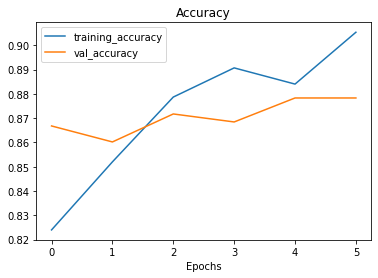

In [70]:
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models that have only been fit once. However, we want something to compare one series of fit() with another (eg before and after running fine-tuning)

In [82]:
# Lets create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs = 5):
    """
    Compares two tensorflow history objects
    """
    # Get original history history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label = "Training Accuracy")
    plt.plot(total_val_acc, label = "Val Accuracy")
    plt.plot([initial_epochs -1, initial_epochs-1], plt.ylim(), label = "Start Fine Tuning")
    plt.legend(loc = "lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(2,1,2)
    plt.plot(total_loss, label = "Training Loss")
    plt.plot(total_val_loss, label = "Val Loss")
    plt.plot([initial_epochs -1, initial_epochs-1], plt.ylim(), label = "Start Fine Tuning")
    plt.legend(loc = "upper right")
    plt.title("Training and Validation Loss")

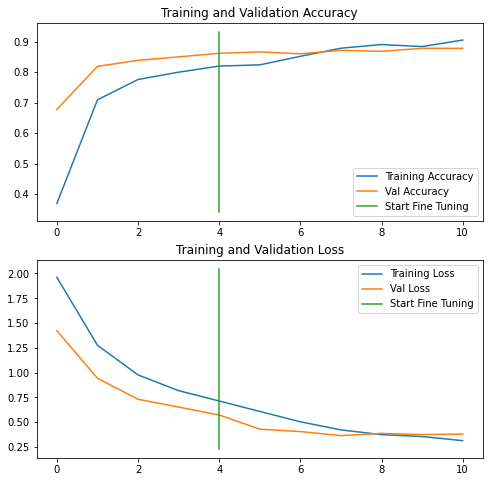

In [83]:
compare_histories(history_2, history_fine_10_percent_data_aug, initial_epochs=5)

## Model 4: Fine-Tuning the existing model on all of the data

In [85]:
train_dir = "Data/Classification/10_food_classes_all_data/train"
test_dir = "Data/Classification/10_food_classes_all_data/test"

train_data_full = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = "categorical",
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
)

test_dir = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = "categorical",
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [86]:
walk_through_dir("Data/Classification/10_food_classes_all_data")

There are 2 directories and 0 images in 'Data/Classification/10_food_classes_all_data'.
There are 10 directories and 0 images in 'Data/Classification/10_food_classes_all_data\test'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in 'Data/Classification/10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in 'Data/Classification/10_food_cl

The test dataset we've loaded in is the same as we've been using for previous experiments (all experiments use the same test dataset)
Let's verify this..

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [87]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [89]:
# Lets evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 9s 106ms/step - loss: 0.6157 - accuracy: 0.8396


[0.6157078146934509, 0.8396000266075134]

In [ ]:
results_fine_tune_10_pct

[0.4066324532032013, 0.8640000224113464]

We've successfully reverted back to the same point where our feature extractor left off.

In [91]:
#Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [93]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [96]:
# Recompile the model
model_2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics = ["accuracy"]
)

In [97]:
# Continue to train and fine-tune the model to our data (100% of training data)

history_fine_10_classes_full = model_2.fit(
    train_data_full,
    epochs = fine_tune_epochs,
    validation_data = test_data,
    validation_steps = int(0.25*len(test_data)),
    initial_epoch = history_2.epoch[-1],
    callbacks = [create_tensorboard_callback("TensorBoard/Classification","full_data_fine_tune_effnetb0")]
)

Saving TensorBoard log files to: TensorBoard/Classification/full_data_fine_tune_effnetb0/20220706-205015
Epoch 5/10
235/235 [==============================] - 91s 357ms/step - loss: 0.5754 - accuracy: 0.8136 - val_loss: 0.2995 - val_accuracy: 0.9062
Epoch 6/10
235/235 [==============================] - 78s 329ms/step - loss: 0.4873 - accuracy: 0.8424 - val_loss: 0.2683 - val_accuracy: 0.9145
Epoch 7/10
235/235 [==============================] - 65s 274ms/step - loss: 0.4412 - accuracy: 0.8587 - val_loss: 0.2644 - val_accuracy: 0.9128
Epoch 8/10
235/235 [==============================] - 62s 264ms/step - loss: 0.3929 - accuracy: 0.8711 - val_loss: 0.2425 - val_accuracy: 0.9243
Epoch 9/10
235/235 [==============================] - 62s 263ms/step - loss: 0.3673 - accuracy: 0.8796 - val_loss: 0.2511 - val_accuracy: 0.9145
Epoch 10/10
235/235 [==============================] - 56s 237ms/step - loss: 0.3433 - accuracy: 0.8889 - val_loss: 0.2454 - val_accuracy: 0.9227


In [98]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 8s 100ms/step - loss: 0.2670 - accuracy: 0.9140


[0.26697444915771484, 0.9139999747276306]

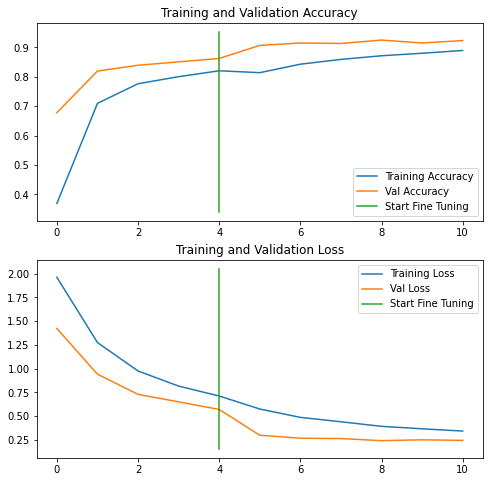

In [99]:
compare_histories(history_2, history_fine_10_classes_full, 5)

And we've successfully trained on Food101 with a fantastic accuracy!